### Imports

In [ ]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras import layers, regularizers, ops
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import (
    Input, Flatten, Concatenate, Dense, BatchNormalization,
    Reshape, LeakyReLU, Dropout
)
from tensorflow.keras.models import Model

### Mounting drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Loading the data

In [ ]:
x_path = '/content/drive/MyDrive/Assignment_2/x_letters.npy'
y_path = '/content/drive/MyDrive/Assignment_2/y_letters.npy'

X = np.load(x_path).astype(np.float64)
Y = np.load(y_path).astype(np.int64)

### Sanity Check

In [ ]:
print("Shape of X:", X.shape)
print("Data type of X:", X.dtype)
print("Shape of Y:", Y.shape)
print("Data type of Y:", Y.dtype)

Shape of X: (88799, 28, 28)
Data type of X: float64
Shape of Y: (88799,)
Data type of Y: int64


### One hot encoding the labels.


In [ ]:
Y = keras.utils.to_categorical(Y, 26)
n_classes = Y.shape[1]

type(n_classes)


int

### Creating a Shuffled and Batched Dataset for Training


In [ ]:
batch_size = 64

dataset = tf.data.Dataset.from_tensor_slices((X, Y))
dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True).batch(batch_size)


### Looking at an example of an image.

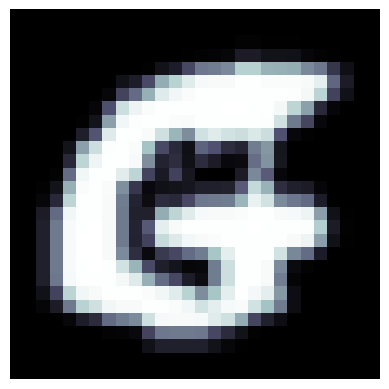

In [ ]:
plt.imshow(X[0], cmap="bone")
plt.axis("off")
plt.show()

#GAN

### Defining custom GAN Class

In [ ]:
 #Source: https://keras.io/examples/generative/dcgan_overriding_train_step/

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")


    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, data):
        # Sample random points in the latent space

        real_images, real_classes = data
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim),
            seed = self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator([random_latent_vectors, real_classes])

        # Combine them with real images
        real_images = real_images * 2 - 1  # Rescale to [-1, 1], because the generator outputs images in the same range (using tanh as last activation function)

        #real_images = tf.expand_dims(real_images, axis=-1) <!-------------------!>
        #combined_images = ops.concatenate([generated_images, real_images], axis=0) # <!----------------CODE TO USE FOR CONV GEN/DIS----------------!>

        combined_images = ops.concatenate([generated_images, real_images], axis=0) #<!----------------CODE TO USE FOR FNN----------------!>
        combined_classes = ops.concatenate([real_classes, real_classes], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)) * 0.9, ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        #basically makes sure the discriminator is not perfect,
        #so that the generator never has a chance to learn
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_classes])
            d_loss = self.loss_fn(labels, predictions)
            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim),
            seed = self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            generated_images = self.generator([random_latent_vectors, real_classes])
            predictions = self.discriminator([generated_images, real_classes])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)

        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),

        }

We modified the GAN class into a Conditional GAN (cGAN), incorporating class labels into both the generator and discriminator.In the cGAN, the generator takes both random noise and real class labels as input, ensuring that it produces images corresponding to specific categories. Similarly, the discriminator receives both images and their respective labels, learning to distinguish between real and generated images while considering their assigned classes. Additionally, the cGAN applies label smoothing by slightly reducing real labels to 0.9 instead of 1.0 to improve stability, we also rescale the real images to the to match the generator’s output which uses the  tanh activation. We still introduce label noise to prevent the discriminator from becoming overly confident.

Generator


In [ ]:
def build_generator():
    noise_input = keras.Input(shape=(latent_dim,))
    label_input = keras.Input(shape=(n_classes,))

    concat = Concatenate(axis=-1)([noise_input, label_input])

    x = Dense(512, activation='relu', kernel_initializer='he_normal')(concat)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)


    x = Dense(28*28, activation='tanh')(x)
    output = Reshape((28, 28))(x)

    return keras.Model([noise_input, label_input], output, name="generator")

Descriminator


In [ ]:
def build_discriminator():
    image_input = keras.Input(shape=(28, 28))
    label_input = keras.Input(shape=(n_classes,))
    flattened_img = Flatten()(image_input)

    x = Dense(512)(flattened_img)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.45)(x)

    x = Dense(256)(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.45)(x)

    concat = Concatenate(axis=-1)([x, label_input])

    x = Dense(128)(concat)
    x = LeakyReLU(0.2)(x)

    output = Dense(1, activation="sigmoid")(x)

    return keras.Model([image_input, label_input], output, name="discriminator",)

Convolutional Generator

In [ ]:
from keras.layers import Conv2DTranspose, Conv2D

def build_conv_generator():
    noise_input = keras.Input(shape=(latent_dim,))
    label_input = keras.Input(shape=(n_classes,))

    concat = Concatenate(axis=-1)([noise_input, label_input])

    x = Dense(7 * 7 * 128, activation="relu")(concat)  # Expand features
    x = Reshape((7, 7, 128))(x)  # Reshape into image feature map

    x = Conv2DTranspose(64, kernel_size=3, strides=2, padding="same")(x)  # Upsample
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2DTranspose(32, kernel_size=3, strides=2, padding="same")(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Conv2DTranspose(1, kernel_size=3, activation="tanh", padding="same")(x)  # Output layer

    return keras.Model([noise_input, label_input], x, name="conv_generator")


Convolutional Discriminator (mostly playting around and trying it out)

In [ ]:
def build_conv_discriminator():
    image_input = keras.Input(shape=(28, 28, 1))  # Input image
    label_input = keras.Input(shape=(n_classes,))  # One-hot encoded label

    x = Conv2D(64, kernel_size=3, strides=2, padding="same")(image_input)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(128, kernel_size=3, strides=2, padding="same")(x)
    x = LeakyReLU(0.2)(x)
    x = Dropout(0.3)(x)

    x = Flatten()(x)  # Convert to dense
    concat = Concatenate(axis=-1)([x, label_input])

    x = Dense(64)(concat)
    x = LeakyReLU(0.2)(x)
    output = Dense(1, activation="sigmoid")(x)  # Classification output

    return keras.Model([image_input, label_input], output, name="conv_discriminator")


In [ ]:
latent_dim = 128

discriminator = build_discriminator()
generator = build_generator()


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(
        learning_rate=0.0002, beta_1=0.5 # beta_1:Reduces past gradient influence, making training more adaptive and stable. Prevents discriminator overpowering generator.
    ),
    g_optimizer=keras.optimizers.Adam(
        learning_rate=0.0001, beta_1=0.5
    ),
    loss_fn=keras.losses.BinaryCrossentropy(),
)


d_loss_history = []
g_loss_history = []

epochs = 50  # Total training epochs
checkpoint_epochs = [1, 10, 20, 30, 40, 50]  # Epochs to save generator

d_loss_history = []
g_loss_history = []

for epoch in range(1, epochs + 1):
    history = gan.fit(dataset, epochs=1, verbose=1)  # Train for 1 epoch

    # Save loss values
    d_loss_history.append(history.history["d_loss"][-1])
    g_loss_history.append(history.history["g_loss"][-1])

    # Save loss history after every epoch
    np.save("d_loss_history.npy", np.array(d_loss_history))
    np.save("g_loss_history.npy", np.array(g_loss_history))

    print(f"Epoch {epoch}/{epochs} - D Loss: {d_loss_history[-1]:.4f}, G Loss: {g_loss_history[-1]:.4f}")

    # Save the generator model at specific epochs
    if epoch in checkpoint_epochs:
        gan.generator.save(f"generator_epoch_{epoch}.keras")  # Save generator
        print(f" Generator model saved at epoch {epoch}")

1388/1388 ━━━━━━━━━━━━━━━━━━━━ 21s 6ms/step - d_loss: 0.4236 - g_loss: 1.8759
Epoch 1/50 - D Loss: 0.3858, G Loss: 1.9533
 Generator model saved at epoch 1
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - d_loss: 0.3911 - g_loss: 1.8272
Epoch 2/50 - D Loss: 0.3843, G Loss: 1.8688
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3707 - g_loss: 1.9673
Epoch 3/50 - D Loss: 0.3648, G Loss: 1.9888
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3636 - g_loss: 1.9683
Epoch 4/50 - D Loss: 0.3663, G Loss: 1.9361
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3705 - g_loss: 1.8929
Epoch 5/50 - D Loss: 0.3699, G Loss: 1.8824
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3700 - g_loss: 1.8648
Epoch 6/50 - D Loss: 0.3690, G Loss: 1.8680
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3719 - g_loss: 1.8816
Epoch 7/50 - D Loss: 0.3715, G Loss: 1.8811
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3708 - g_loss: 1.8888
Epoch 8/50 - D Loss: 0.3700, G Loss: 1.88

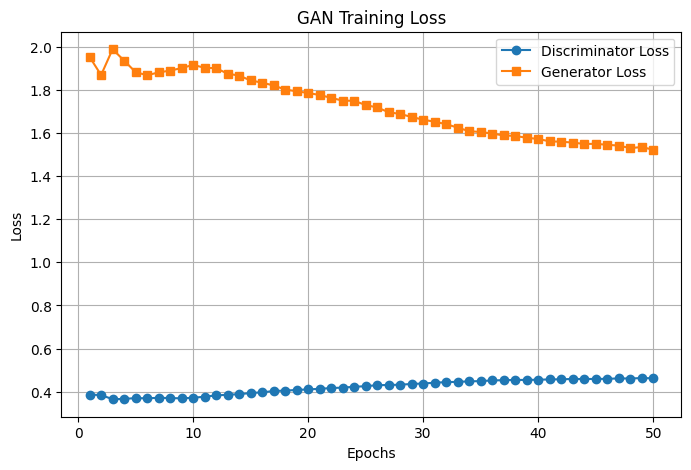

In [ ]:
# Load the saved loss history
d_loss_history = np.load("d_loss_history.npy")
g_loss_history = np.load("g_loss_history.npy")

epochs = range(1, len(d_loss_history) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, d_loss_history, label='Discriminator Loss', marker='o', linestyle='-')
plt.plot(epochs, g_loss_history, label='Generator Loss', marker='s', linestyle='-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GAN Training Loss')
plt.legend()
plt.grid()
plt.show()


In [ ]:
#mapping table to get the index of the letter (class) to onehot
mapping = {
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'e': 4,
    'f': 5,
    'g': 6,
    'h': 7,
    'i': 8,
    'j': 9,
    'k': 10,
    'l': 11,
    'm': 12,
    'n': 13,
    'o': 14,
    'p': 15,
    'q': 16,
    'r': 17,
    's': 18,
    't': 19,
    'u': 20,
    'v': 21,
    'w': 22,
    'x': 23,
    'y': 24,
    'z': 25
}

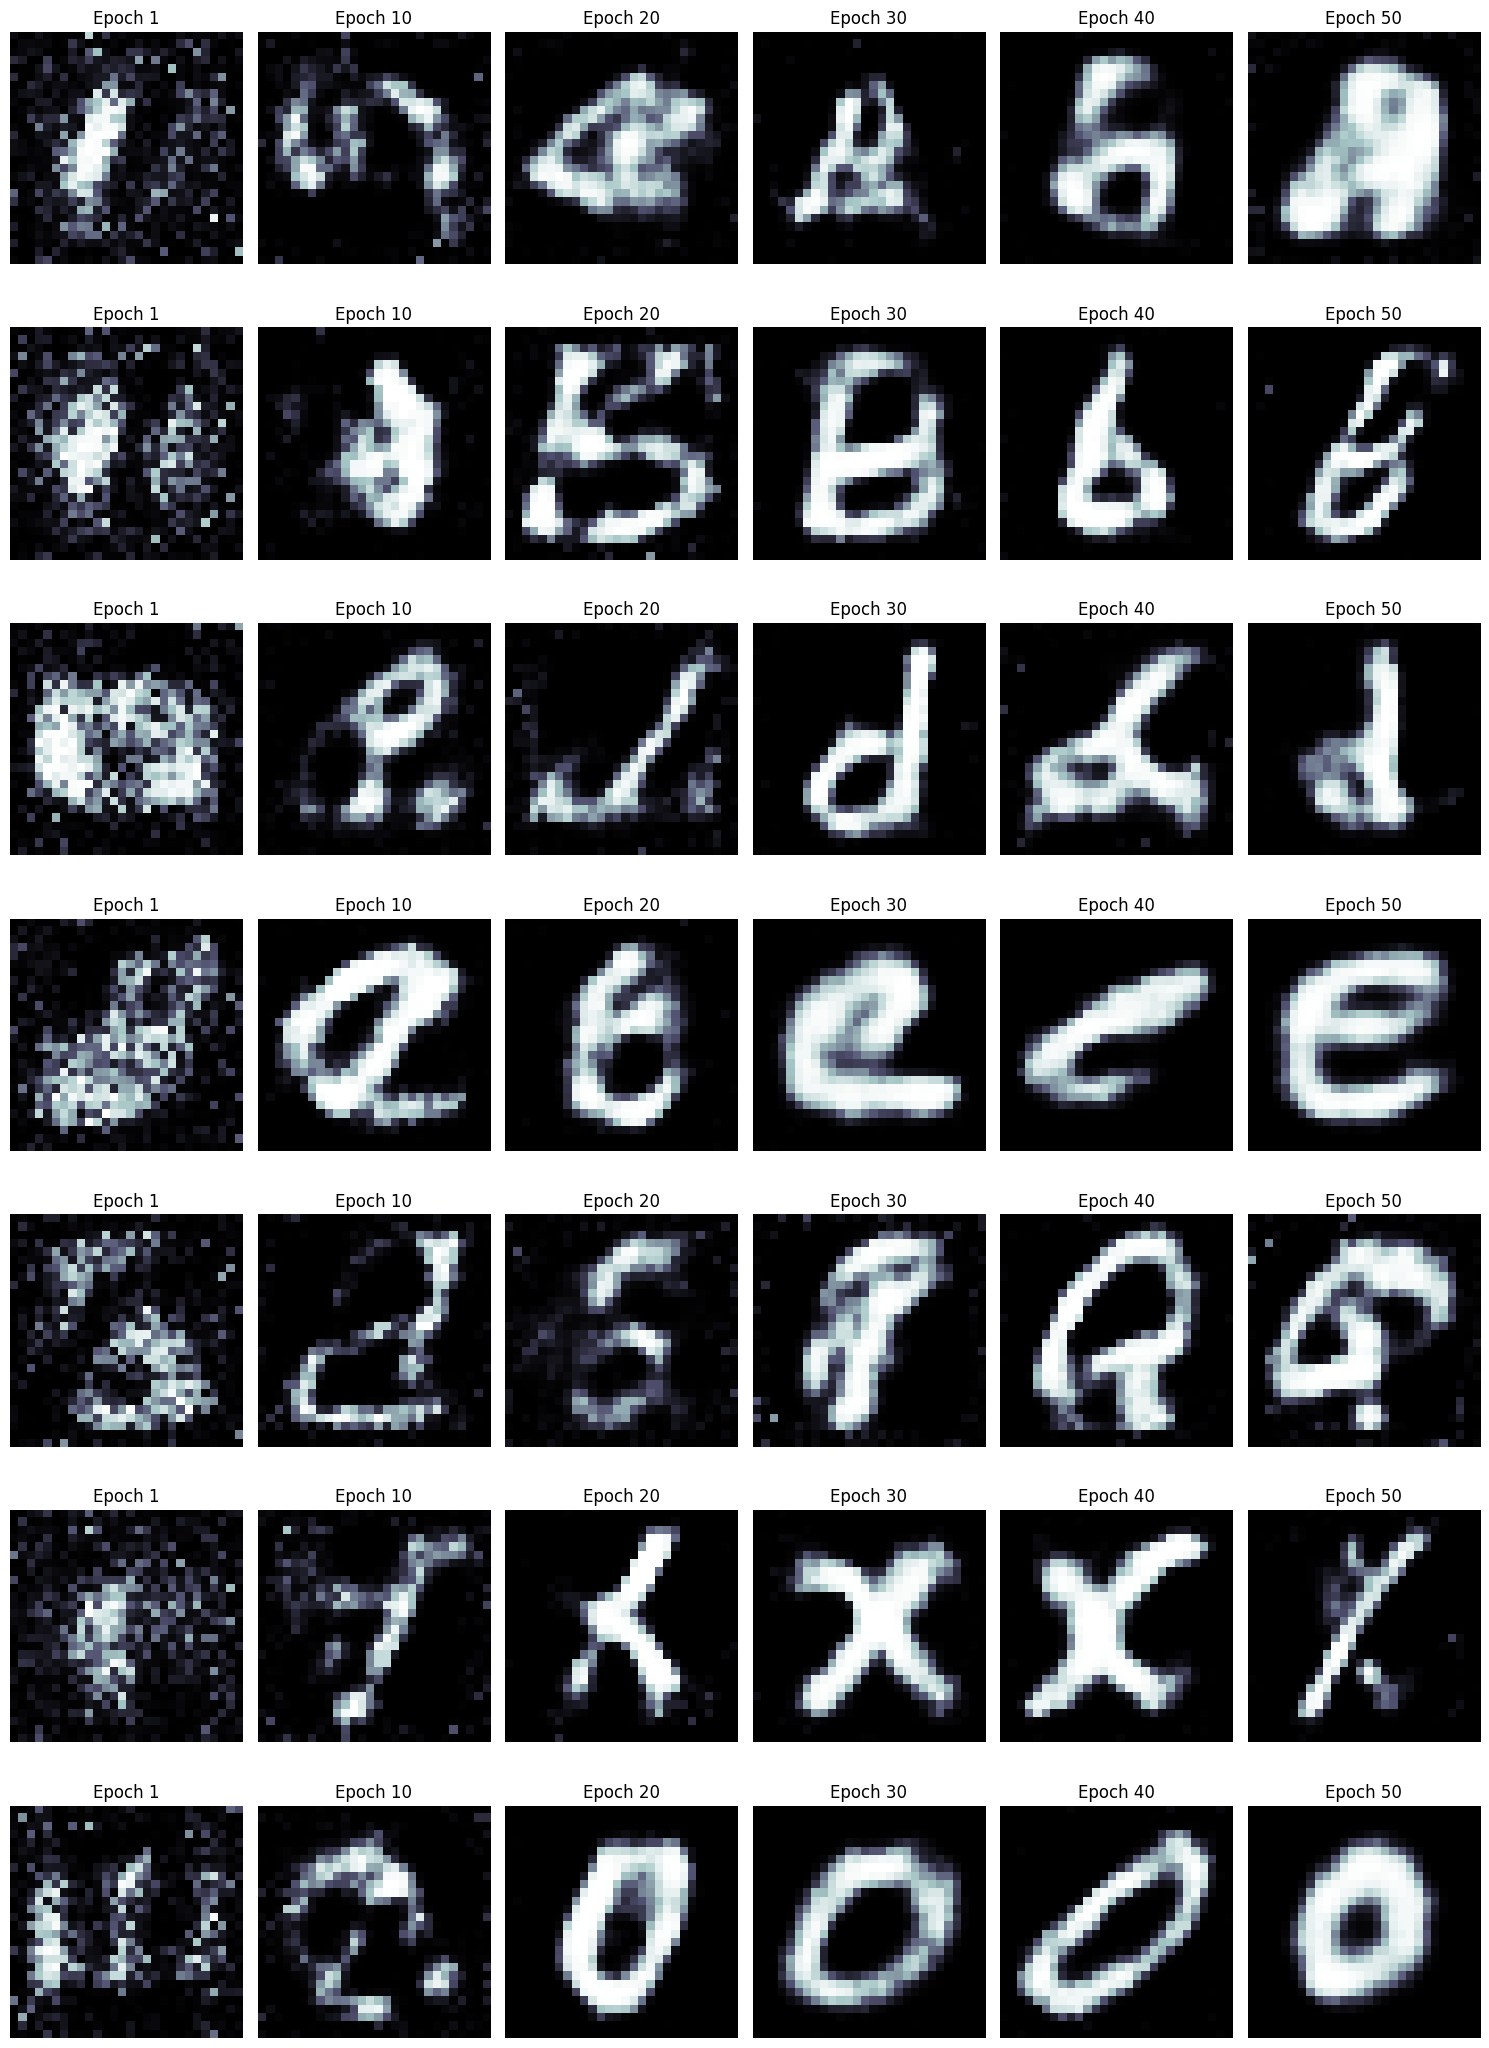

In [ ]:
checkpoint_epochs = [1, 10, 20, 30, 40, 50]  # Epochs saved
letters = ['a', 'b', 'd', 'e', 'q', 'x', 'o']  # Choose multiple letters
mapped_letters = [mapping[letter] for letter in letters]

fig, axes = plt.subplots(len(letters), len(checkpoint_epochs), figsize=(15, 3 * len(letters)))

for row, mapped_letter in enumerate(mapped_letters):
    for col, epoch in enumerate(checkpoint_epochs):
        # Load generator from a specific epoch
        generator = load_model(f"generator_epoch_{epoch}.keras")

        # Generate letter from the loaded model
        latent_vector = keras.random.normal(shape=(1, latent_dim))
        one_hot_label = tf.expand_dims(ops.one_hot(mapped_letter, num_classes=n_classes), axis=0)

        generated_image = generator([latent_vector, one_hot_label]).numpy()[0]

        axes[row, col].imshow(generated_image, cmap="bone")
        axes[row, col].set_title(f"Epoch {epoch}")
        axes[row, col].axis("off")

plt.tight_layout()
plt.show()


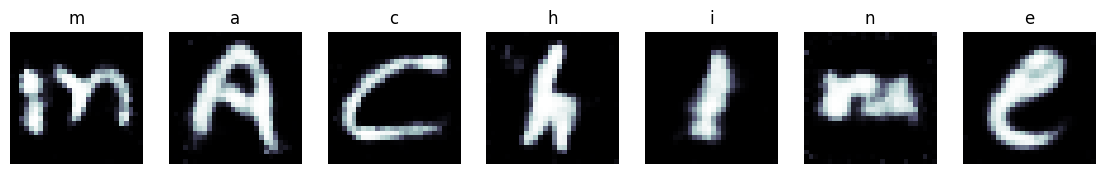

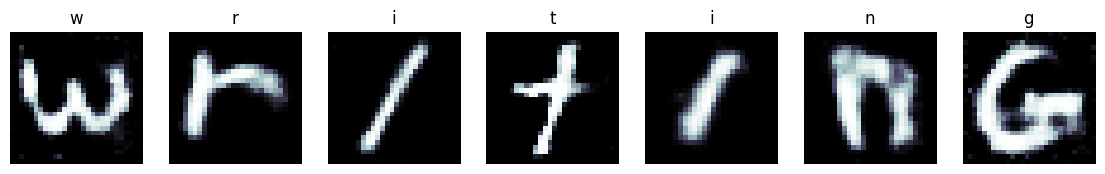

In [ ]:
def generate_word(word):
    """Generates and displays a word using the generate_letter function."""
    fig, axes = plt.subplots(1, len(word), figsize=(len(word) * 2, 2))

    if len(word) == 1:
        axes = [axes]

    for ax, letter in zip(axes, word):
        mapped_letter = mapping[letter]
        random_latent_vectors = keras.random.normal(shape=(1, latent_dim))
        one_hot_label = (ops.one_hot(mapped_letter, num_classes=n_classes))
        one_hot_label = tf.expand_dims(one_hot_label, axis=0)

        generated_images = gan.generator([random_latent_vectors, one_hot_label])
        generated_images = generated_images.numpy()[0]

        ax.imshow(generated_images, cmap="bone")
        ax.set_title(letter)
        ax.axis("off")

    plt.show()

# Usage
generate_word("machine")
generate_word("writing")


# Findings And Comments

 During the development of the GAN, a variety of experiments were done to improve the GAN by modifying network architecture, optimizer selection and hyperparameter tuning

 Multiple optimizers were tested such as RMSprop,Adam,SGD before ultimately settling with Adam(learning_rate=0.0001, beta_1=0.5) based on best practices found on the internet(Link-2)

 We experimented with varying depths and layer sizes to improve the GAN as well as modifying latent space size

 We also utilized a graph plotting g_loss and d_loss to monitor the loss for generator and discriminator as well as manually seeing how the model generated images and different epoch lengths in order to help us tweak the GAN

#Link1:

# https://keras.io/examples/generative/conditional_gan/



# Link2:

# https://arnavkartikeya.medium.com/best-practices-for-gans-3e2d4d2c2daf#:~:text=Lastly%2C%20the%20optimizer%20commonly%20used,weights%20more%20accurately%20and%20efficiently.